In [1]:
using NBInclude
using LinearAlgebra

@nbinclude("julia_function.ipynb")

allskyts (generic function with 1 method)

In [2]:
# Matrix construction functions

# Constants dependent on energy
function c(u, du, dr)
    e = 10^u
    effarea(e) * 10000 * flx(e) * du * dr * 10^u * log(10) * 3
end

# Oscillation and bin volume
function o(dm2, u, r, dr, l, b, θ)
    e = 10^u
    oscprob(e, dm2, r) * sbinarea.((r+dr), l, b, θ)
end

# Pure oscillation matrix (just the cosine dependent terms)
function matrixOsc(dm2, bins)

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)
    # dr = rs[2] - rs[1]

    O = [oscprob(e, dm2, r) for e in es, r in rs]
end

# Full matrix with energy and bin size terms
function matrixA(dm2, l, b, bins)  

    us = range(log10(emin), log10(emax), bins)

    rs = range(0, 30, bins)

    du = us[2] - us[1]
    dr = rs[2] - rs[1]

    A = [c(u, du, dr)*o(dm2, u, r, dr, l, b, 0.005) for u in us, r in rs]

end

# Pure oscillation matrix with energy bounds left free
function matrixOsc1(dm2, bins, umin, umax)

    us = range(umin, umax, bins)
    es = 10 .^ us
    rs = range(0, 30, bins)

    O = [oscprob(e, dm2, r) for e in es, r in rs]
end

# ONLY the cosine terms, no PMNS matrix vals
function justosc(dm2, bins)

    function cososc(dm2, e, r)
        convfactor = 3.086e19 * 5.06773093741 * 1e6
        r *= convfactor
        osc = (cos((dm2 * r)/(4*e*1e12)))^2
    end

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)
    dr = rs[2] - rs[1]

    justO = [cososc(dm2, e, r+dr) for e in es, r in rs]

end

justosc (generic function with 1 method)

In [3]:
# Matrix manipulation functions

# Absolute value of the determinant of the oscillation matrix
function Odet(dm2, bins)
    d = abs(det(matrixOsc(dm2, bins)))
end

function Adet(dm2, l, b, bins)
    d = abs(det(matrixA(dm2, l, b, bins)))
end

function Osc1det(dm2, bins, umin, umax)
    d = abs(det(matrixOsc1(dm2, bins, umin, umax)))
end

function justoscdet(dm2, bins)
    d = abs(det(justosc(dm2, bins)))
end

justoscdet (generic function with 1 method)

In [4]:
# Event distribution calculation functions

# Approximate binned perfect event distribution
function perfectedistapprox(dm2, l, b, θ, nsteps)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, nsteps)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 3
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    # du = (log10(emax) - log10(emin)) / nsteps
    us = range(log10(emin), log10(emax), nsteps)

    du = us[2] - us[1]

    output = f.(us) .* du .* (10 .^ us) .* log(10)
end

# Fully integrated perfect event distribution
function perfectedist(dm2, l, b, θ, nbins)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, nsteps)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 3
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = f.(us) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

perfectedist (generic function with 1 method)

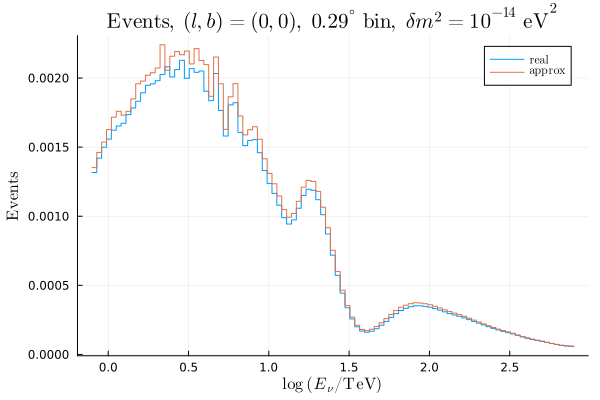

In [18]:
# Plotting approximate vs true perfect event distributions

ebinnum = 100

ebins = range(log10(emin), log10(emax), ebinnum)

real = perfectedist(10^(-13), 0, 0, 0.005, ebinnum)
approx = perfectedistapprox(10^(-13), 0, 0, 0.005, ebinnum)

plot(
    ebins,
    [real approx],
    seriestype=:step,
    title=L"\mathrm{Events},~(l, b) = (0, 0),~0.29^{\circ}~\mathrm{bin},~\delta m^2 = 10^{-14}~\mathrm{eV}^2",
    label=[L"\mathrm{real}" L"\mathrm{approx}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}"
)

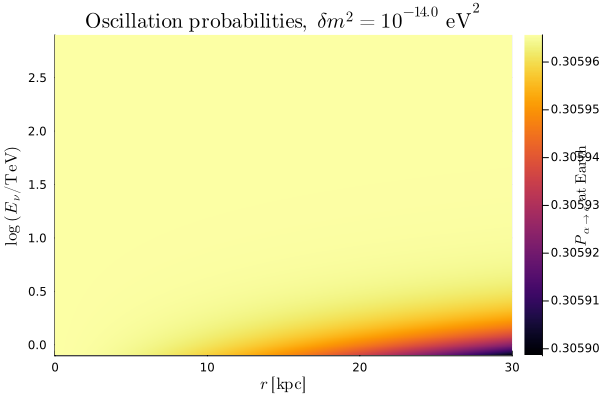

In [8]:
# Plotting the oscillation probabilities

us = range(log10(emin), log10(emax), 1000)
rs = range(0, 30, 1000)

O = matrixOsc(10^(-17), 1000)

heatmap(
    rs,
    us,
    O,
    title=L"\mathrm{Oscillation~probabilities},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"P_{\alpha \to e}~\mathrm{at~Earth}"
)

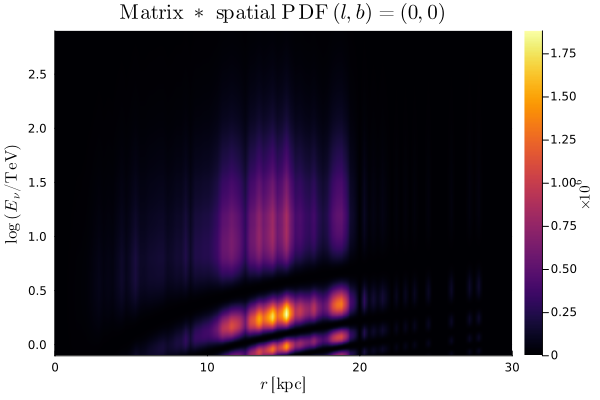

In [9]:
# Plotting the full matrix

nbins = 1000
dm2 = 10^(-14)

us = range(log10(emin), log10(emax), nbins)

rs = range(0, 30, nbins)

A = matrixA(dm2, 0, 0, nbins)

for j in 1:nbins
    for i in 1:nbins
        A[i, j] *= probdens(cartx(rs[j], 0, 0), carty(rs[j], 0, 0), cartz(rs[j], 0, 0))
    end
end

heatmap(
    rs,
    us,
    A .* 1000000,
    title=L"\mathrm{Matrix}~*~\mathrm{spatial~PDF}~(l, b) = (0, 0)",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"\times 10^6"
)

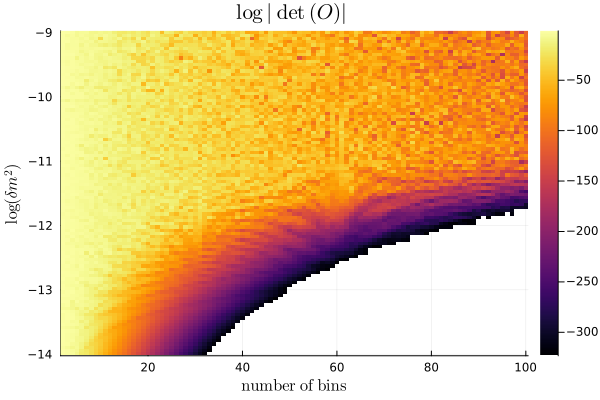

In [10]:
# Plotting the matrix determinant

binss = 2:1:100

logdm2s = range(-14.0, -9.0, length=100)
dm2s = 10 .^ logdm2s

detOmat = [Odet(dm2, bins) for dm2 in dm2s, bins in binss]

heatmap(
    binss,
    logdm2s,
    log10.(detOmat),
    title=L"\log~|\det~(O)|",
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"\log (\delta m^2)",
    color=:inferno
)

In [153]:
# Spatial PDF calculation functions

# The true PDF
function pdtrue(dm2, l, b, bins)

    rbins = range(0, 30, bins)

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

end

# The reconstruction going off of the approximate binned event distribution, with the pseudoinverse matrix algorithm
function pdreconstruct(dm2, l, b, bins)

    mat = matrixA(dm2, l, b, bins)

    eventsvec = perfectedistapprox(dm2, l, b, 0.005, bins)

    sol = pinv(mat) * eventsvec

end

# Calculating the accuracy of the above reconstruction
function recoaccuracy(dm2, bins, l, b)

    truepd = pdtrue(dm2, l, b, bins)

    recpd = pdreconstruct(dm2, l, b, bins)

    # acc = norm((recpd .- truepd) ./ truepd)
    accvec = norm(recpd .- truepd) / norm(truepd)

end

# Unmodified algorithm for the reconstruction accounting for the correct perfect edist
# Very incorrect
function pdreconstruct1(dm2, l, b, bins)

    mat = matrixA(dm2, l, b, bins)

    eventsvec = perfectedist(dm2, l, b, 0.005, bins)

    sol = pinv(mat) * eventsvec

end

# Reconstruction accounting for the correct perfect edist, CORRECT (I think) minimization algorithm with
# initial value left free
function pdreconstructapprox(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    # Map from R^bins to R, so should have a gradient
    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        output = norm((A * solapprx) - pdperfect)
    end

    x0 = zeros(1, bins) .+ ival
    optim = optimize(approx1, x0)
    params = Optim.minimizer(optim)
    return vec(params)
end

function pdreconstructapprox_grad(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    # Map from R^bins to R, so should have a gradient
    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        # Squaring the function for easier computation
        output = (norm((A * solapprx) - pdperfect))^2
    end

    # Test gradient
    function g!(G, solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        innervec = (A * solapprx) - pdperfect
        for i in 1:bins
            G[i] = 2*dot(A[:, i], innervec)
        end
        # G = [2*dot(A[:, i], innervec) for i in 1:bins]
    end

    x0 = zeros(1, bins) .+ ival
    optim = optimize(approx1, g!, x0, LBFGS())
    params = Optim.minimizer(optim)
    return vec(params)
end

function pdreconstructapprox_constrained(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    # Map from R^bins to R, so should have a gradient
    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        # Squaring the function for easier computation
        output = (norm((A * solapprx) - pdperfect))^2
    end

    # Test gradient
    function g!(G, solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        innervec = (A * solapprx) - pdperfect
        for i in 1:bins
            G[i] = 2*dot(A[:, i], innervec)
        end
        # G = [2*dot(A[:, i], innervec) for i in 1:bins]
    end

    x0 = zeros(1, bins) .+ ival
    # Setting bounds
    lower = zeros(1, bins)
    upper = zeros(1, bins) .+ 0.01
    optim = optimize(approx1, g!, lower, upper, x0, Fminbox(GradientDescent()))
    params = Optim.minimizer(optim)
    return vec(params)
end



pdreconstructapprox_constrained (generic function with 1 method)

In [154]:
recovec_grad = pdreconstructapprox(10^(-14), 0, 0, 10, 0.003)
# recovec_nograd = pdreconstructapprox(10^(-14), 0, 0, 50, 0.003)

10-element Vector{Float64}:
  0.02014584862860312
  0.01814086236998472
 -0.009363434796108383
  0.00605600594167982
 -0.004186866579660039
  0.008618918268752308
  0.00898252772649223
 -0.01270801083650803
 -0.00045613512378827546
  0.004119174978171604

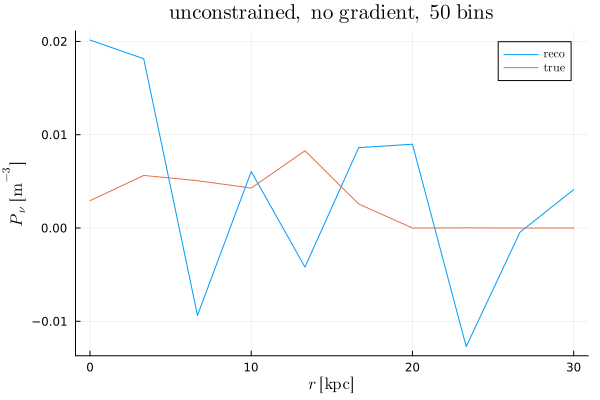

In [155]:
plot(
    range(0, 30, 10),
    [recovec_grad pdtrue(10^(-14), 0, 0, 10)],
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\mathrm{unconstrained,~no~gradient,~50~bins}"
)

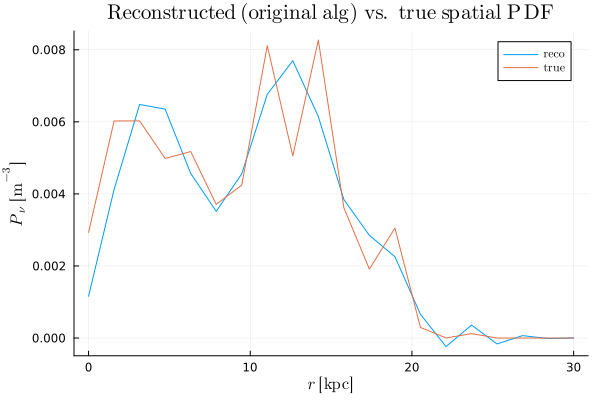

In [21]:
# Plotting the original reconstruction vs. the true PDF

nbins = 20

rbins = range(0, 30, nbins)

plot(
    rbins,
    [pdreconstruct(10^(-14), 0, 0, nbins) pdtrue(10^(-14), 0, 0, nbins)],
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\mathrm{Reconstructed~(original~alg)~vs.~true~spatial~PDF}",
)


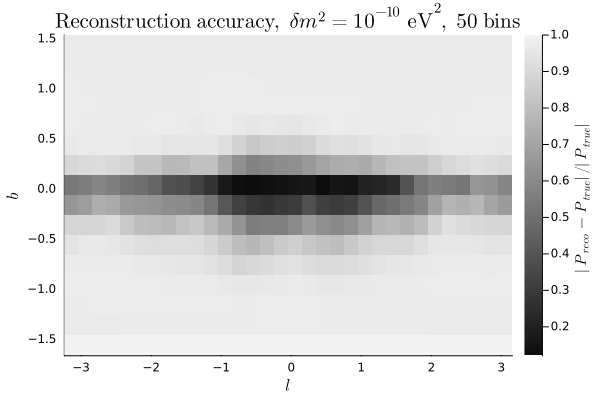

In [19]:
# Plotting accuracies of the original reconstruction algorithm

ls = -π:0.2:π
bs = (-π/2):0.2:(π/2)

testmat = [recoaccuracy(10^(-10), 50, l, b) for b in bs, l in ls]

heatmap(
    ls,
    bs,
    testmat,
    c=:grays,
    colorbar_title=L"|P_{reco} - P_{true}| / |P_{true}|",
    title=L"\mathrm{Reconstruction~accuracy},~\delta m^2 = 10^{-10}~\mathrm{eV}^2,~50~\mathrm{bins}",
    xlabel=L"l",
    ylabel=L"b"
)


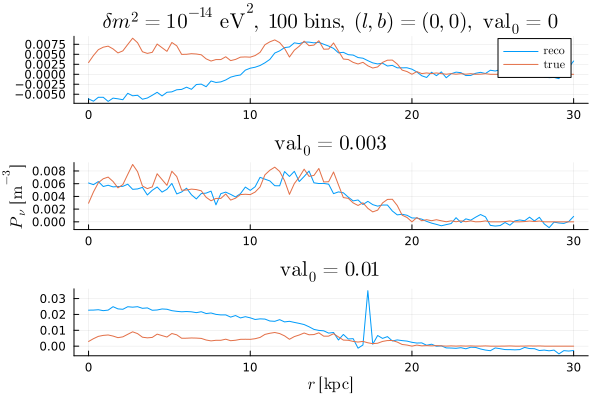

In [690]:
# New reco algorithm with varying the initial vector that's minimized

bins = 100; dm2 = 10^(-14.0)

rbins = range(0, 30, bins)

plot0 = plot(
    rbins,
    [pdreconstructapprox(dm2, 0, 0, bins, 0) pdtrue(dm2, 0, 0, bins)],
    # xlabel=L"r~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\delta m^2 = 10^{-14}~\mathrm{eV}^2,~100~\mathrm{bins},~(l, b) = (0, 0),~\mathrm{val}_0 = 0"
)

plot1 = plot(
    rbins,
    [pdreconstructapprox(dm2, 0, 0, bins, 0.003) pdtrue(dm2, 0, 0, bins)],
    # xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    # label=[L"\mathrm{reco}" L"\mathrm{true}"],
    label=false,
    title=L"\mathrm{val}_0 = 0.003"
)

plot3 = plot(
    rbins,
    [pdreconstructapprox(dm2,0, 0, bins, 0.01) pdtrue(dm2, 0, 0, bins)],
    xlabel=L"r~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    # label=[L"\mathrm{reco}" L"\mathrm{true}"],
    label=false,
    title=L"\mathrm{val}_0 = 0.01"
)

plot(plot0, plot1, plot3, layout=(3,1))

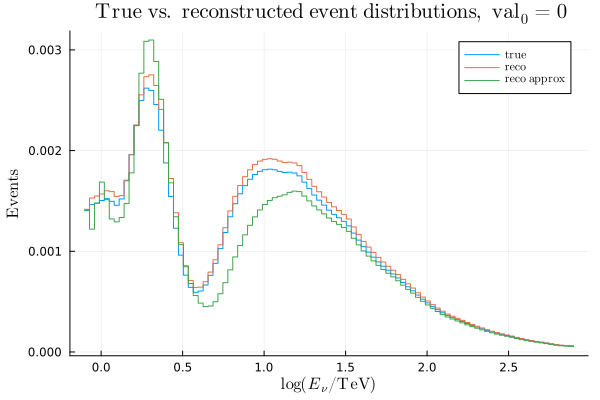

In [23]:
# Plotting the event distributions that result from different PDF reconstruction algs

bins = 100; dm2 = 10^(-14)

ebins = range(log10(emin), log10(emax), bins)

recoedistapprox = matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0.0)
recoedist = matrixA(dm2, 0, 0, bins) * pdreconstruct(dm2, 0, 0, bins)

plot(
    ebins,
    [perfectedist(dm2, 0, 0, 0.005, bins) recoedist recoedistapprox],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{true}" L"\mathrm{reco}" L"\mathrm{reco~approx}"],
    title=L"\mathrm{~True~vs.~reconstructed~event~distributions},~\mathrm{val}_0 = 0"
)

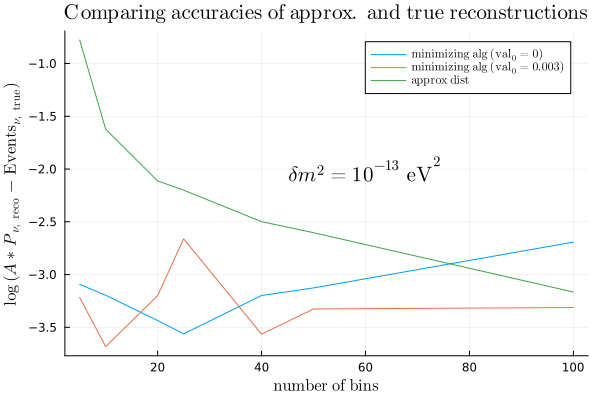

In [41]:
# Plotting the difference between the accuracies of different reconstructions algorithms as a function of bin number

dm2 = 10^(-13)
binss = [5, 10, 20, 25, 40, 50, 100]

accs = [norm(matrixA(dm2, 0, 0, bins) * pdreconstruct(dm2, 0, 0, bins) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]
accsapprox0 = [norm(matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]
accsapprox3 = [norm(matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0.003) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]

plot(
    binss,
    [log10.(accsapprox) log10.(accsapprox3) log10.(accs)],
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"\log~(A * P_{\nu,~\mathrm{reco}} - \mathrm{Events}_{\nu,~\mathrm{true}})",
    label=[L"\mathrm{minimizing~alg}~(\mathrm{val}_0 = 0)" L"\mathrm{minimizing~alg}~(\mathrm{val}_0 = 0.003)" L"\mathrm{approx~dist}"],
    title=L"\mathrm{Comparing~accuracies~of~approx.~and~true~reconstructions}",
    ann=[(60, -2, L"\delta m^2 = 10^{-13}~\mathrm{eV}^2")]
)

In [13]:
dm2 = 10^(-14)
bins = 100
val0s = range(0, 0.005, 20)
l  = π; b = 0

accs = [norm(matrixA(dm2, l, b, bins) * pdreconstructapprox(dm2, l, b, bins, val0) .- perfectedist(dm2, l, b, 0.005, bins)) for val0 in val0s]

20-element Vector{Float64}:
 1.6127541241716623e-5
 0.0003205571422012288
 0.0003905357988087615
 0.0005545238740329563
 0.000696386676259623
 0.0008476998112025052
 0.0009952368004722838
 0.0014104834254544715
 0.0015497687950463653
 0.0019423564518583581
 0.0020642978010431794
 0.002335137992656921
 0.0025473202803134106
 0.0026020332616344733
 0.0030323734592368947
 0.003661802065632739
 0.004188577772070715
 0.004413122745495012
 0.005116899224248163
 0.005713096372204489

In [14]:
writedlm("misc_data/pd_rec0_accs_diff_val0_vals_anti_GC_bin.txt", accs)

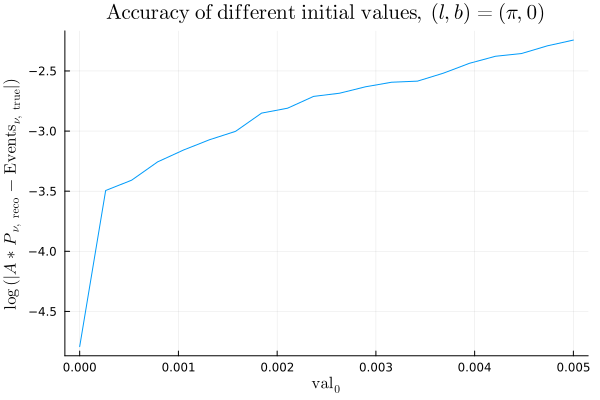

In [156]:
plot(
    val0s,
    log10.(accs),
    xlabel=L"\mathrm{val}_0",
    ylabel=L"\log~(\| A * P_{\nu,~\mathrm{reco}} - \mathrm{Events}_{\nu,~\mathrm{true}}\|)",
    label=false,
    title=L"\mathrm{Accuracy~of~different~initial~values},~(l, b) = (\pi, 0)"
)

In [19]:
Amat = [1 2; 3 4]
Amat[:, 1]

2-element Vector{Int64}:
 1
 3